# A Notebook To Accompany the centgovspend Library

This is a notebook to accompany the [centgovspend](https://github.com/crahal/centgovspend/) project. It first imports data and necessary libraries/modules, then outputs some summary statistics and a longitudinal over-view of the data which is aggregated by the library.

## Section 1: Importing Data and Libraries

Lets first load our favourite tools! Everything here is pretty much bundled with Anaconda other than gender_guesser (```pip install gender_guesser```) and ezodf (```pip install ezodf```). A requirements.txt accompanies the repository.

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import re
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import seaborn as sns
from clean_matches import clean_matches
import matplotlib as mpl
import gender_guesser.detector as gender
gendet = gender.Detector()
sns.set(style='ticks')
%matplotlib inline
%load_ext autoreload
%autoreload 2

Then lets load the main payments and reconciliation datasets generated by the library (outputs of ```centgovspend/src/centgovspend·py```):

In [2]:
payments = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'output', 'master',
                 'All_Merged_Unmatched.csv')),
    encoding="ISO-8859-1", sep=',', engine='python',
    dtype={'transactionnumber': str,
           'supplier': str,
           'supplier_upper': str,
           'date': str,
           'expensearea': str,
           'expensetype': str,
           'file': str,
           'amount': float})
payments['date'] = payments['date'].apply(pd.to_datetime,
                                          dayfirst=True,
                                          errors = 'coerce')
replacedict = pd.read_csv((os.path.abspath(
    os.path.join('__file__', '../..', 'data',
                 'support', 'dept_names_dict.csv'))),
                          header=None,
                          dtype={0: str}).set_index(0).squeeze().to_dict()
for key, value in replacedict.items():
    payments['dept'] = payments['dept'].replace(key,value)
    
recon_sup = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'output',
                 'master', 'Reconciled_Suppliers.tsv')),
    encoding="ISO-8859-1", sep='\t')
recon_sup = recon_sup.drop(['Disputed Office', 'Third Match',
                            'Third ID', 'Third Score'], axis=1)
matched = pd.merge(payments, recon_sup, how='left', left_on='supplier_upper',
    right_on='RawSupplier').dropna(subset=['Best Match'])

## Section 2. Summary Statistics

Lets print out some summary statistics from just the parsed datasets. These should exactly match the print --> stdout commands generated by ```evaluate_and_clean_merge``` in ```centgovspend/src/evaluate·py```:

In [3]:
print('We matched ' + str(len(matched)) + ' out of ' + str(len(payments)) +
      ' payments in total (' + str(round(((len(matched) /
                                           len(payments)) * 100), 2)) + '%).')
print('We matched £' + str(int(matched['amount'].sum())) + ' out of ' +
      '£' + str(int(payments['amount'].sum())) +
      ' value in total (' + str(int(round(((matched['amount'].sum() /
                                        payments['amount'].sum()) *
                                       100), 2))) + '%).')
print('We matched ' + str(len(matched['supplier_upper'].unique())) + ' out of ' +
      str(len(payments['supplier_upper'].unique())) +
      ' unique suppliers in total (' +
      str(round(((len(matched['supplier_upper'].unique()) /
                  len(payments['supplier_upper'].unique())) * 100), 2)) + '%).')

We matched 384528 out of 752023 payments in total (51.13%).
We matched £253474597826 out of £1248914548666 value in total (20%).
We matched 15136 out of 35874 unique suppliers in total (42.19%).


## Section 3. Longitudinal Analysis

Lets analyze the bounty of procurement data which we ourselves have procured, and overlay the three critical policy junctures at different points in time. In general note that we are saving .pdfs for the TeX paper, and .pngs to be hosted and called by the readme.md of the repo:

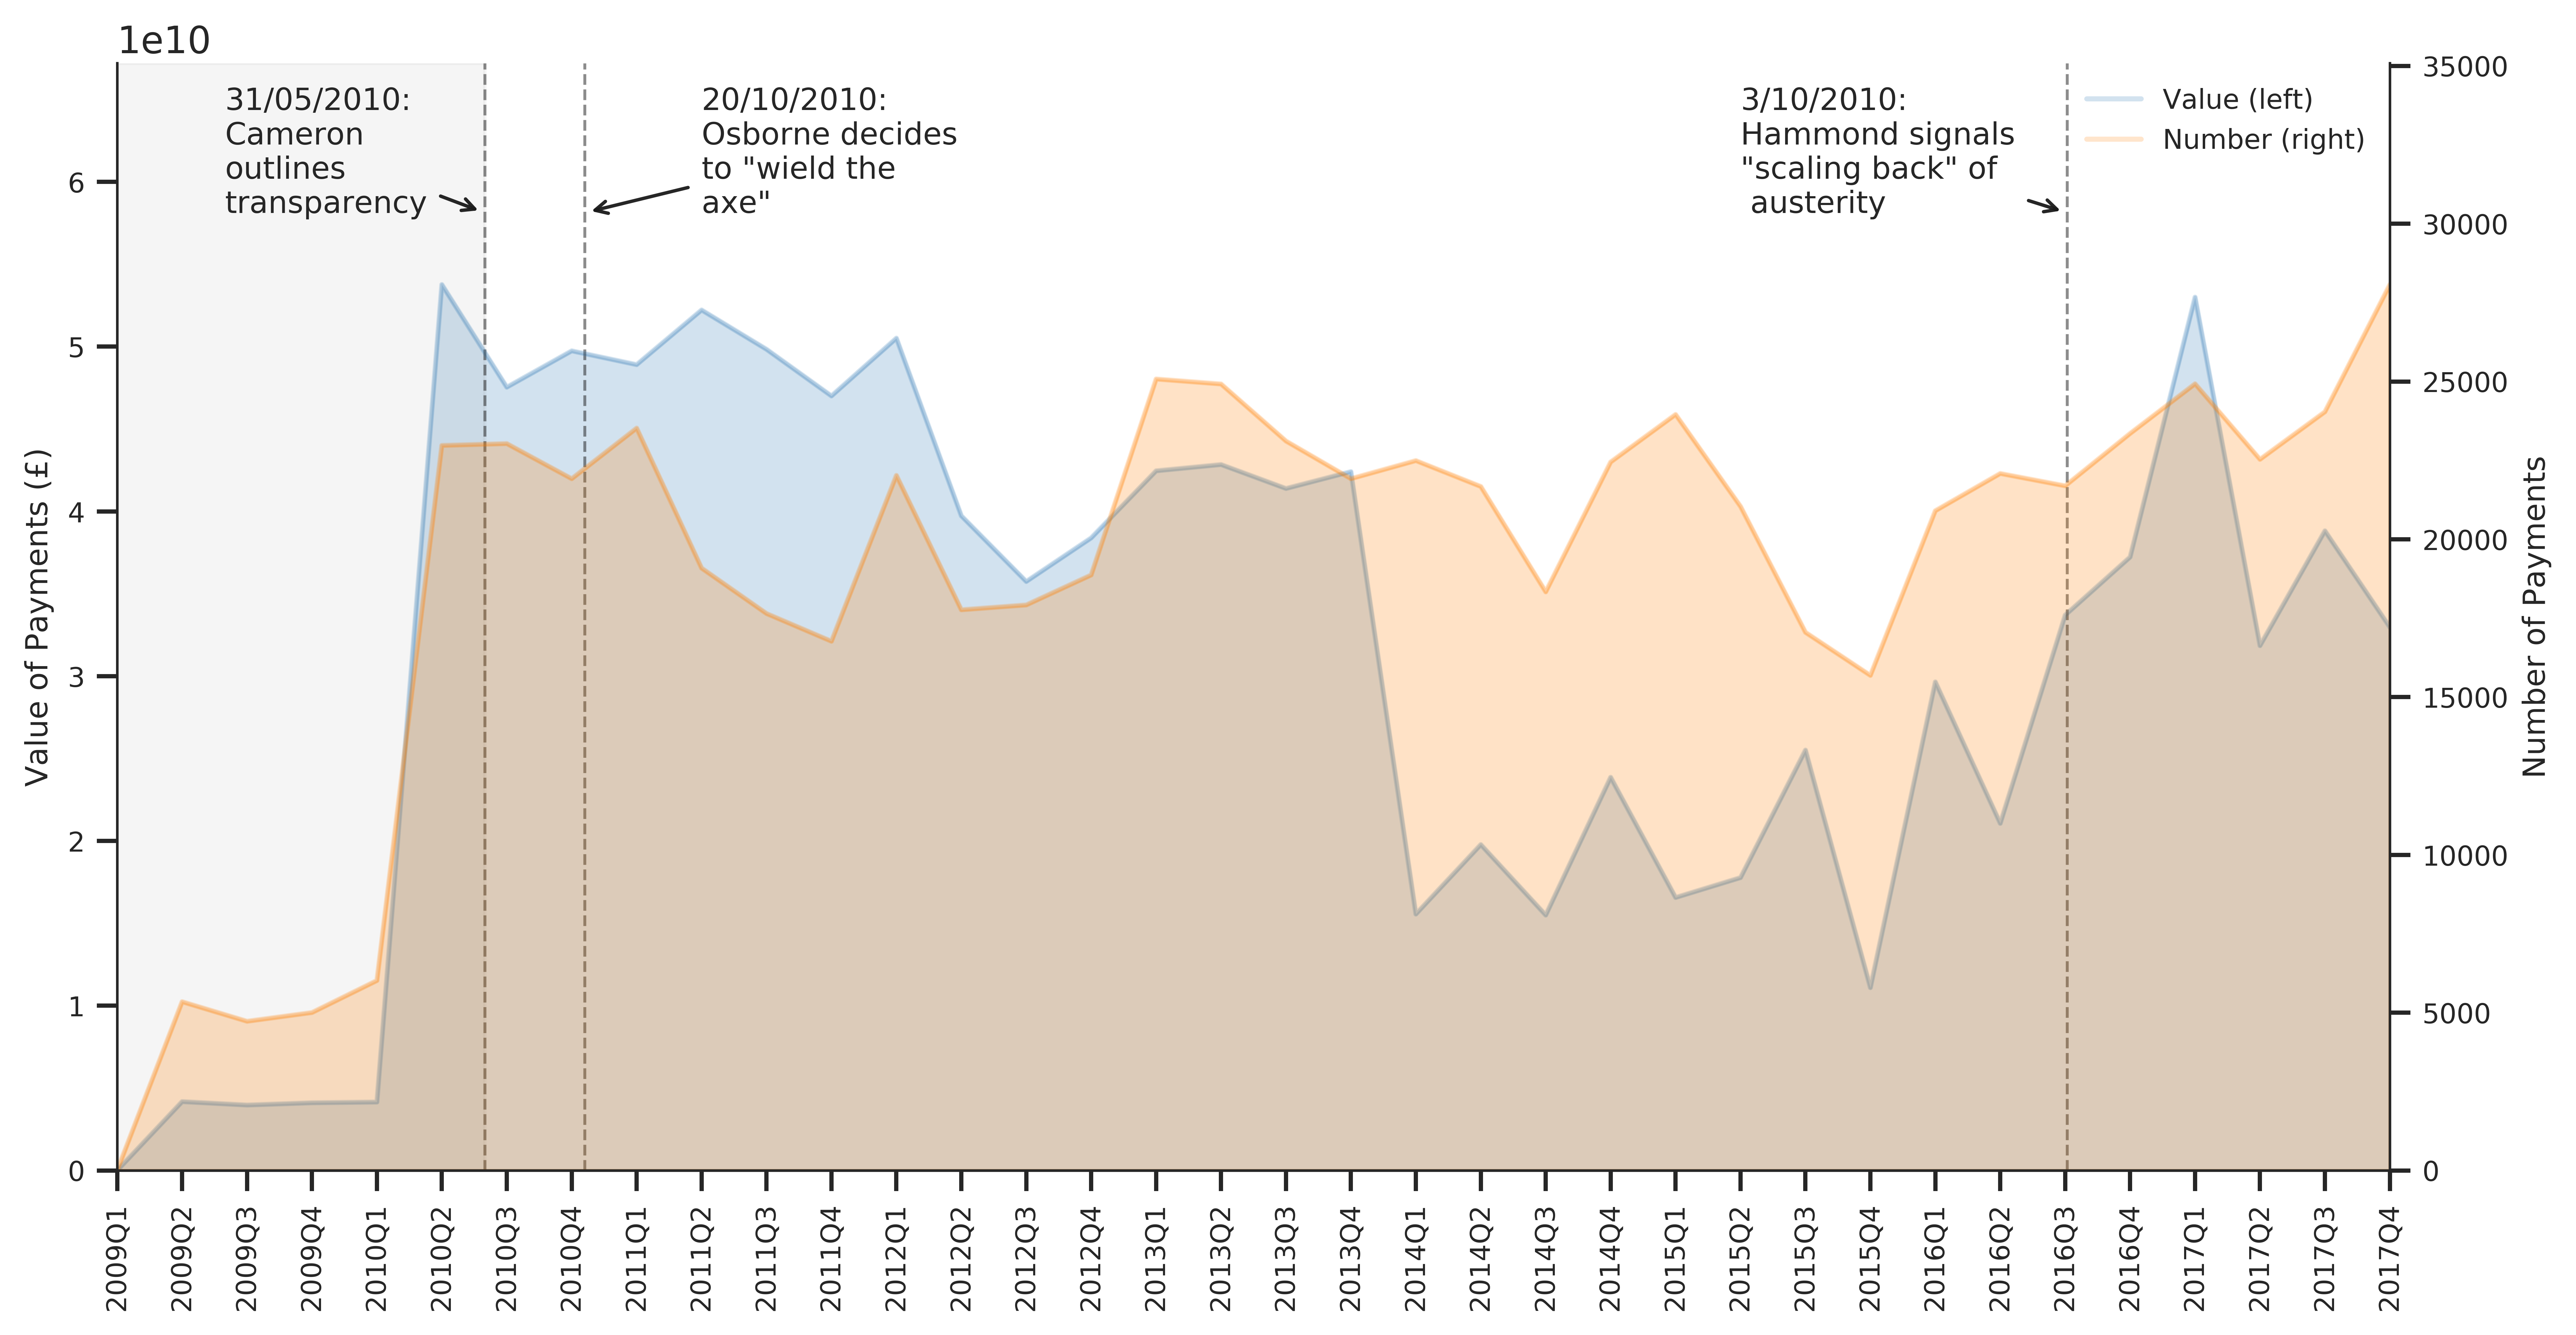

In [4]:
timely_df = pd.DataFrame(columns=['Number of Payments', 'Value of Payments'])
numberpayments = 0
valuepayments = 0
for year in list(range(2009, 2018)):
    timely_df.at[str(year) + 'Q1', 'Number of Payments'] = len(payments[
        (payments['date'].dt.month <= 3) &
        (payments['date'].dt.year == year)])
    timely_df.at[str(year) + 'Q1', 'Value of Payments'] = payments[
        (payments['date'].dt.month <= 3) &
        (payments['date'].dt.year == year)]['amount'].sum()
    timely_df.at[str(year) + 'Q2', 'Number of Payments'] = len(payments[
        (3 < payments['date'].dt.month) &
        (payments['date'].dt.month <= 6) &
        (payments['date'].dt.year == year)])
    timely_df.at[str(year) + 'Q2', 'Value of Payments'] = payments[
        (3 < payments['date'].dt.month) &
        (payments['date'].dt.month <= 6) &
        (payments['date'].dt.year == year)]['amount'].sum()
    timely_df.at[str(year) + 'Q3', 'Number of Payments'] = len(payments[
        (6 < payments['date'].dt.month) &
        (payments['date'].dt.month <= 9) &
        (payments['date'].dt.year == year)])
    timely_df.at[str(year) + 'Q3', 'Value of Payments'] = payments[
        (6 < payments['date'].dt.month) &
        (payments['date'].dt.month <= 9) &
        (payments['date'].dt.year == year)]['amount'].sum()
    timely_df.at[str(year) + 'Q4', 'Number of Payments'] = len(payments[
        (9 < payments['date'].dt.month) &
        (payments['date'].dt.month <= 12) &
        (payments['date'].dt.year == year)])
    timely_df.at[str(year) + 'Q4', 'Value of Payments'] = payments[
        (9 < payments['date'].dt.month) &
        (payments['date'].dt.month <= 12) &
        (payments['date'].dt.year == year)]['amount'].sum()
timley_resetindex = timely_df.reset_index()
fig = plt.figure(figsize=(12, 6), dpi=800)
axC = fig.add_subplot(1, 1, 1)
ax_2a = timley_resetindex[['Value of Payments']].plot(kind='area',
                                                      ax=axC,
                                                      color='#377eb8',
                                                      legend=False,
                                                      alpha=0.225)
ax_2b = timley_resetindex[['Number of Payments']].plot(kind='area',
                                                       ax=axC.twinx(),
                                                       color='#ff7f00',
                                                       legend=False,
                                                       alpha=0.225)
ax_2a.set_xticks(timley_resetindex.index)
ax_2a.set_xticklabels(timley_resetindex['index'], rotation=90)
ax_2a.vlines(x=5.66, ymin=0,
             ymax=timley_resetindex['Value of Payments'].max()/0.8,
             color='k', linestyle='--',
             alpha=0.5, linewidth=0.85)
ax_2a.annotate('31/05/2010:\nCameron\noutlines\ntransparency',
               xy=(5.66, timley_resetindex['Value of Payments'].max()/0.925),
               xytext=(1.66, timley_resetindex['Value of Payments'].max()/0.925),
               arrowprops=dict(color='k', arrowstyle="->", alpha=0.95), size=9)
ax_2a.vlines(x=7.2, ymin=0,
             ymax=timley_resetindex['Value of Payments'].max()/0.8,
             color='k', linestyle='--',
             alpha=0.5, linewidth=0.85)
ax_2a.annotate('20/10/2010:\nOsborne decides\nto "wield the\naxe"',
               xy=(7.2, timley_resetindex['Value of Payments'].max()/0.925),
               xytext=(9, timley_resetindex['Value of Payments'].max()/0.925),
               arrowprops=dict(color='k', arrowstyle="->", alpha=0.95), size=9)
ax_2a.vlines(x=30.03, ymin=0,
             ymax=timley_resetindex['Value of Payments'].max()/0.8,
             color='k', linestyle='--',
             alpha=0.5, linewidth=0.85)
ax_2a.annotate('3/10/2010:\nHammond signals\n"scaling back" of\n austerity',
               xy=(30.03, timley_resetindex['Value of Payments'].max()/0.925),
               xytext=(25, timley_resetindex['Value of Payments'].max()/0.925),
               arrowprops=dict(color='k', arrowstyle="->", alpha=0.95), size=9)
ax_2a.set_ylim(0, timley_resetindex['Value of Payments'].max()/0.8)
ax_2b.set_ylim(0, timley_resetindex['Number of Payments'].max()/0.8)
ax_2a.spines['top'].set_visible(False)
ax_2b.spines['top'].set_visible(False)
ax_2a.axvspan(0, 5.66, alpha=0.075, color='grey')
ax_2a.margins(0.0)
ax_2a.spines['right'].set_visible(False)
ax_2a.spines['left'].set_visible(False)
ax_2a.set_ylabel("Value of Payments (£)", size=9)
ax_2b.set_ylabel("Number of Payments", size=9)
for axis in ['top', 'bottom', 'left', 'right']:
    ax_2a.spines[axis].set_linewidth(0.75)
    ax_2b.spines[axis].set_linewidth(0.75)
axC.plot(0, 0, '-r', color='#ff7f00', markersize=7, alpha=0.2,
         markeredgecolor='k', markeredgewidth=0.5)
leg = axC.legend(['Value (left)', 'Number (right)'],
                 fontsize=8, loc='upper right', frameon=False)
ax_2a.tick_params(labelsize=8)
ax_2b.tick_params(labelsize=8)
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'timeline.pdf')), bbox_inches='tight')
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'timeline.png')),dpi=600, bbox_inches='tight')

## Section 4. Matching Algorithms

### Section 4.1 Visualising the Matches

What do the matches look like? Plot as seperate figures because of the way that ```compile/paper/centgovspend.tex``` renders subfigures:

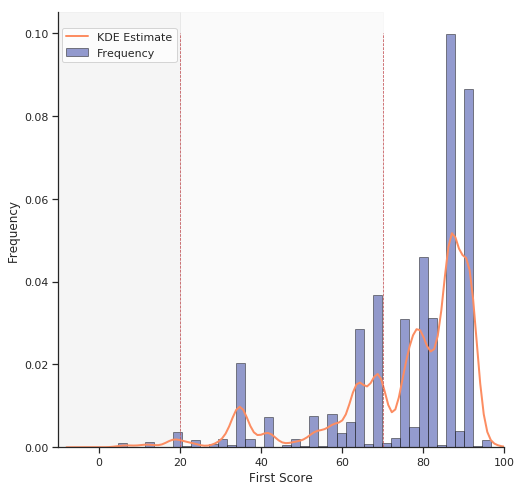

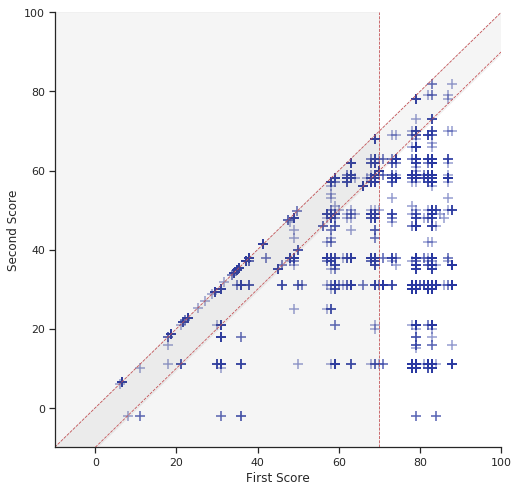

In [5]:
sns.set(style='ticks')
f, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
h = sns.distplot(recon_sup[~pd.isnull(recon_sup['First Match'])]['First Score'],
                 bins=44,
                 kde_kws={"color": "#fc8d62",
                          "lw": 2, "label": "KDE Estimate",
                          "alpha": 1},
                 hist_kws={"color": "#2938a0",
                           "alpha": 0.5, "label": "Frequency",
                           'edgecolor': 'k'},
                 ax=ax1)
h.set(ylabel="Frequency")
h.set_xlim(xmin=-10, xmax=100)
h.plot([20, 20], [0, .1], color='r', linestyle='--', linewidth=0.75)
h.plot([70, 70], [0, .1], color='r', linestyle='--', linewidth=0.75)
h.legend(loc='center left', bbox_to_anchor=(-0.004, 0.925),frameon=True)
h.axvspan(-20, 20, alpha=0.08, color='grey')
h.axvspan(20, 70, alpha=0.04, color='grey')
sns.despine(right=True, top=True, ax=ax1)
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'mostmatch_and_safematch_a.pdf')),
          bbox_inches='tight')
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'mostmatch_and_safematch_a.png')), dpi=600, bbox_inches='tight')

f, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
g = sns.regplot(x="First Score", y="Second Score", data=recon_sup,
                fit_reg=False, ax=ax1, color='#2938a0', marker='+',
                scatter_kws={'s':120, 'alpha':0.5})
g.set_xlim(xmin=-10, xmax=100)
g.set_ylim(ymin=-10, ymax=100)
r2 = patches.Rectangle((0, -20), 7.5, 200, color = "grey",  alpha=0.08)
t2 = mpl.transforms.Affine2D().rotate_deg(-45) + g.transData
r2.set_transform(t2)
g.add_patch(r2)
r1 = patches.Rectangle((70, -10), -80, 110, color="grey",  alpha=0.08)
g.add_patch(r1)
g.plot([-10, 100], [-10, 100], color='r', linestyle='--', linewidth=0.8)
g.plot([0, 100], [-10, 90], color='r', linestyle='--', linewidth=0.8)
g.plot([70, 70], [-10, 100], color='r', linestyle='--', linewidth=0.8)
sns.despine(right=True, top=True, ax=ax1)
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'mostmatch_and_safematch_b.pdf')), bbox_inches='tight')
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'mostmatch_and_safematch_b.png')), dpi=600,
          bbox_inches='tight')

### Section 4.2 Lets Evaluate our Matching Algorithm

Lets see exactly how our safematch algorithm performs. The denominators should match those above and those from ```evaluate_and_clean.py```

In [6]:
recon_clean = clean_matches(recon_sup, 'automated_safe')
recon_clean['company_number'] = recon_clean['Best ID'].str.replace('/companies/gb/','')
matched_clean = pd.merge(payments,
                         recon_clean,
                         how='left',
                         left_on='supplier_upper',
                         right_on='RawSupplier').dropna(subset=['Best Match'])
print('\nWe matched ' + str(len(matched_clean)) + ' out of ' + str(len(payments)) +
      ' payments in total (' + str(round(((len(matched_clean) /
                                           len(payments)) * 100), 2)) + '%).')
print('We matched £' + str(int(matched_clean['amount'].sum())) + ' out of ' +
      '£' + str(int(payments['amount'].sum())) +
      ' value in total (' + str(int(round(((matched_clean['amount'].sum() /
                                        payments['amount'].sum()) *
                                       100), 2))) + '%).')
print('We matched ' + str(len(matched_clean['supplier_upper'].unique())) +
      ' out of ' + str(len(payments['supplier_upper'].unique())) +
      ' unique suppliers in total (' +
      str(round(((len(matched_clean['supplier_upper'].unique()) /
                  len(payments['supplier_upper'].unique())) * 100), 2)) + '%).')

***Undertaking an automated safe reconciliation!***

We matched 269405 out of 752023 payments in total (35.82%).
We matched £131432026967 out of £1248914548666 value in total (10%).
We matched 10506 out of 35874 unique suppliers in total (29.29%).


## Section 5. Briefly Analyze Which Companies get What:

### Section 5.1 Tabulate Across Companies

In [7]:
sup_numpays = pd.DataFrame(matched_clean.groupby(
    ['Best Match']).size(), columns=['Number of Payments'])
sup_value = pd.DataFrame(pd.DataFrame(matched_clean.groupby(['Best Match'])[
                         'amount'].agg('sum'))).rename(
    columns={'amount': 'Value of Payments'})
sup_both = pd.concat([sup_value, sup_numpays], axis=1).reset_index()
recon_sup_for_match = recon_sup[['Best Match','Postcode','SIC Code','Type',
                                 'First Score',
                                 'Best ID']].drop_duplicates(subset='Best Match')
sup_both = pd.merge(sup_both, recon_sup_for_match, how='left',
                    left_on='Best Match', right_on='Best Match')
sup_both = sup_both.sort_values(ascending=False, by='Value of Payments')[0:20]
sup_both['ID'] = sup_both['Best ID'].str.replace('/companies/gb/', '')
sup_both['Best Match'] = sup_both['Best Match'].str.title()
sup_both = sup_both.set_index('Best Match')
sup_both['SIC Code'] = sup_both['SIC Code'].str.replace("[", '')
sup_both['SIC Code'] = sup_both['SIC Code'].str.replace(']', '')
sup_both['SIC Code'] = sup_both['SIC Code'].str.replace("'", "")
sup_both[['Value of Payments', 'Number of Payments',
          'Postcode', 'SIC Code', 'Type']].style

,Value of Payments,Number of Payments,Postcode,SIC Code,Type
Best Match,,,,,
Student Loans Company Limited,1.64676e+10,29,DL1 1RW,64929,ltd
British Broadcasting Corporation,1.36433e+10,189,nan,nan,royal-charter
Post Office Limited,9.87981e+09,996,EC2Y 9AQ,"53100, 64999",ltd
Crossrail Limited,4.44847e+09,26,E14 5LQ,42120,ltd
Atos It Services Uk Limited,2.79367e+09,7154,WC1V 6EA,"26200, 62090, 70229, 86900",ltd
Airwave Solutions Limited,2.44671e+09,1827,SW1E 5LB,61900,ltd
Ibm United Kingdom Limited,2.14404e+09,4613,PO6 3AU,26200,ltd
Connect Plus (M25) Limited,2.11871e+09,966,EN6 3NP,42110,ltd
Fujitsu Services Limited,2.05837e+09,5481,W1U 3BW,"58290, 62020, 62090, 95110",ltd


### 5.2 Split Across Departments:

In [8]:
depts_df = pd.DataFrame(columns=['Files', 'Spend (£m)', 'Total Payments',
                                 '% to Prviate', 'Most Frequent PS Supplier'],
                        index=payments['dept'].unique())
for dept in matched_clean['dept'].unique():
    depts_df.loc[dept, 'Files'] = len(payments[payments['dept'] ==
                                               dept]['file'].unique())
    depts_df.loc[dept, 'Spend (£m)'] = round(
        payments[payments['dept'] == dept]['amount'].sum() / 1000000, 2)
    depts_df.loc[dept, 'Total Payments'] = len(
        payments[payments['dept'] == dept])
    depts_df.loc[dept,
                 'Most Frequent PS Supplier'] = matched_clean[matched_clean['dept']
                                                      == dept]['Best Match'].value_counts().sort_values(ascending=False).index[0]
    depts_df.loc[dept, '% to Prviate'] = round((matched_clean[matched_clean['dept'] ==
                                                        dept]['amount'].sum(
    ) / payments[payments['dept'] == dept]['amount'].sum()) * 100, 2)

depts_df.sort_values(by='Spend (£m)',ascending=False)[0:20]

,Files,Spend (£m),Total Payments,% to Prviate,Most Frequent PS Supplier
D. Health,52,473447,51469,1.28,CSC COMPUTER SCIENCES LIMITED
D. Educ,94,219531,60157,8.51,CAPGEMINI UK PLC
D. Trans,90,162871,147715,19.51,ATKINS LIMITED
Home Office,162,143709,135535,10.06,INTERSERVE (FACILITIES MANAGEMENT) LTD
D. Int Dev,93,58169.1,55044,9.15,ADAM SMITH INTERNATIONAL LTD
DWP,99,55762.5,120992,16.18,INGEUS UK LIMITED
DBIS,14,41315.4,4415,32.58,POST OFFICE LIMITED
DCMS,50,20900.2,4794,78.96,TOPMARK CLAIMS MANAGEMENT LIMITED
DEFRA,67,20092,38319,18.09,IBM UNITED KINGDOM LIMITED
MHCLG,7,14028.3,16067,0.8,OXFORD INNOVATION SERVICES LIMITED


### 5.3 Across SIC categories

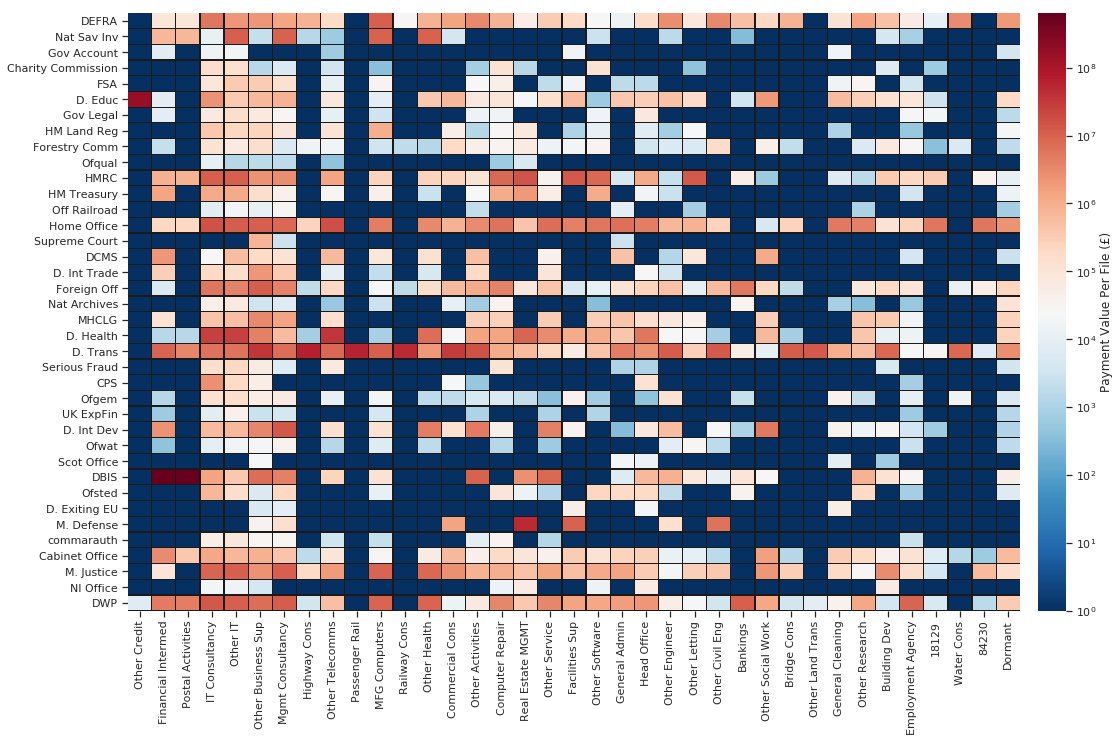

In [9]:
with open(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'output',
                 'master', 'Single_SICs.tsv')), 'w') as sicfile:
    sicfile.write('amount\tdept\tsic\n')
    for index, row in matched_clean.iterrows():
        if pd.isnull(row['SIC Code']) is False:
            for sic in row['SIC Code'].split(','):
                sic = re.findall('\\b\\d+\\b', sic)[0]
                sicfile.write(str(row['amount']) + '\t' + 
                              row['dept'] + '\t' + str(sic)+'\n')
sicfile = pd.read_csv(os.path.abspath(
    os.path.join('__file__',
                 '../..',
                 'data',
                 'output',
                 'master',
                 'Single_SICs.tsv')), sep = '\t', encoding='latin-1')
sicfile = sicfile[sicfile['amount']>25000]
replacedict = pd.read_csv((os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'support', 'sic_renamer.csv'))),
                          header=None,
                          dtype={0: str}).set_index(0).squeeze().to_dict()
for key, value in replacedict.items():
    sicfile['sic'] = sicfile['sic'].replace(int(key),value)
    
sup_value = pd.DataFrame(pd.DataFrame(matched_clean.groupby(['Best Match'])['amount'].agg('sum')))
uniquedepts = sicfile['dept'].unique()
top_sics = pd.DataFrame(sicfile.groupby(['sic'])['amount'].agg('sum')).sort_values(by='amount',
                                                                                   ascending=False)[0:37].index
sicdept_df = pd.DataFrame(columns = top_sics, index = uniquedepts)
for dept in uniquedepts:
    for sic in list(sicdept_df):
        sicdept_df.loc[dept,sic] = (sicfile[(sicfile['sic']==sic) &
                                            (sicfile['dept']==dept)]['amount'].sum()/depts_df.loc[dept,'Files'])
fig, ax = plt.subplots(figsize=(16,11))
sicdept_df=sicdept_df.astype(float)
sicdept_df[sicdept_df <= 0] = 1
log_norm = LogNorm(vmin=sicdept_df.min().min(), vmax=sicdept_df.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(sicdept_df.min().min())),
                                             1+math.ceil(math.log10(sicdept_df.max().max())))]
cbar_ax = fig.add_axes([.915, 0.125, .025, .755])
g = sns.heatmap(sicdept_df,
                linewidths=0.25,
                linecolor='k',
                cmap="RdBu_r",
                cbar_ax = cbar_ax,
                ax = ax,
                norm=log_norm,
                cbar_kws={"ticks": cbar_ticks, 'label': 'Payment Value Per File (£)'})
g.set_ylabel('');
g.set_xlabel('');
fig = g.get_figure()
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'sic_dept_heatmap.pdf')), bbox_inches='tight')
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'sic_dept_heatmap.png')), dpi=600, bbox_inches='tight')

## Section 6. Sociological Stratification of Officers and PSCs

Lets first load the supplementary CH data on Officers and Persons of Signifciant Control (PSCs). Because the files are quite large, only load the datasets which we are actually going to use (i.e. ```usecols```):

In [10]:
ch_psc = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'companies_house',
                 'psc_flatfile.tsv')),
    encoding="ISO-8859-1", sep='\t', error_bad_lines=False,
                    dtype={'company_number': str,
                           'name':str,
                           'nationality':str,
                           'forename': str,
                           'date_of_birth':object,
                           'country_of_residence':str},
                    usecols=['company_number',
                             'date_of_birth',
                             'name',
                             'nationality',
                             'country_of_residence',
                             'forename'])
ch_officers = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'companies_house',
                 'ch_full_officers.tsv')),
    encoding="ISO-8859-1", sep='\t', error_bad_lines=False, 
                          warn_bad_lines = False,
                dtype={'CompanyNumber': str,
                       'Name': str,
                       'Occupation':str,
                       'Nationality':str,
                       'Country of Residence':str},
                usecols = ['CompanyNumber',
                           'Name',
                           'Nationality',
                           'Date of Birth',
                           'Occupation',
                           'Country of Residence'])

### Section 6.1 Compare Officer and PSC Age in CH and the Subset of ```centgovspend``` Procurers

Lets first visualise the age distribution of officers and PSCs between the entire CH and the subset which is supplying central government:

In [11]:
ch_officers_age = ch_officers[ch_officers['Date of Birth'].notnull()]
ch_officers_age = ch_officers_age[ch_officers_age['Date of Birth'].str.contains('year')]
ch_officers_age_uni = pd.DataFrame(ch_officers_age['Date of Birth'].drop_duplicates(),
                                   columns=['Date of Birth']) # this stops us evaluating the same date millions of times
ch_officers_age_uni['Evaluated Date'] = ch_officers_age_uni['Date of Birth'].apply(lambda x: dict(eval(x)))
ch_officers_age_uni = pd.merge(ch_officers_age_uni['Evaluated Date'].apply(pd.Series),
                                      ch_officers_age_uni,left_index=True,right_index=True)
ch_officers_age = pd.merge(ch_officers_age, ch_officers_age_uni, left_on='Date of Birth',
                          right_on='Date of Birth',how='left')
ch_officers_age = ch_officers_age[(ch_officers_age['year'] >= 1900)
                          & (ch_officers_age['year'] <= 2018)]
ch_officers_age['Cleaned Date'] = ch_officers_age['year'].map(
    str) + '-' + ch_officers_age['month'].map(str) + '-01'
ch_officers_age['Age'] = pd.to_datetime(
    'today').year - pd.to_datetime(ch_officers_age['Cleaned Date']).dt.year
ch_officers_age = ch_officers_age[ch_officers_age['Age'].notnull()]
ch_officers_age = ch_officers_age[ch_officers_age['Age']>0]
ch_officers_age = ch_officers_age[ch_officers_age['Age']<=100]                  
recon_officers_age = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_age, how='left', left_on='company_number',
                                right_on='CompanyNumber')
recon_officers_age = recon_officers_age[recon_officers_age['Age'].notnull()]

In [12]:
ch_psc_age = ch_psc[ch_psc['date_of_birth'].notnull()]
ch_psc_age_uni = pd.DataFrame(ch_psc_age['date_of_birth'].drop_duplicates(),columns=['date_of_birth'])
ch_psc_age_uni['Evaluated Date'] = ch_psc_age_uni['date_of_birth'].apply(lambda x: dict(eval(x)))
ch_psc_age_uni = pd.merge(ch_psc_age_uni['Evaluated Date'].apply(pd.Series),
                          ch_psc_age_uni,left_index=True,right_index=True)
ch_psc_age = pd.merge(ch_psc_age, ch_psc_age_uni, left_on='date_of_birth',
                          right_on='date_of_birth',how='left')
ch_psc_age = ch_psc_age[(ch_psc_age['year'] >= 1900)
                          & (ch_psc_age['year'] <= 2018)]
ch_psc_age['Cleaned Date'] = ch_psc_age['year'].map(
    str) + '-' + ch_psc_age['month'].map(str) + '-01'
ch_psc_age['Age'] = pd.to_datetime(
    'today').year - pd.to_datetime(ch_psc_age['Cleaned Date']).dt.year
#ch_psc_age = ch_psc_age[ch_psc_age['Age'].notnull()]
#ch_psc_age = ch_psc_age[ch_psc_age['Age']>0]
#ch_psc_age = ch_psc_age[ch_psc_age['Age']<=100]
recon_psc_age = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_psc_age, how='left', left_on='company_number',
                                right_on='company_number')
recon_psc_age = recon_psc_age[recon_psc_age['Age'].notnull()]

In [13]:
ch_psc_age_filtered = ch_psc_age[(0<=ch_psc_age['Age']) &
                                 (ch_psc_age['Age']<100)]['Age']
recon_psc_age_filtered = recon_psc_age[(0<=recon_psc_age['Age']) &
                                    (recon_psc_age['Age']<100)]['Age']
ch_officers_age_filtered = ch_officers_age[(0<=ch_officers_age['Age']) &
                                                  (ch_officers_age['Age']<100)]['Age']
recon_officers_age_filtered = recon_officers_age[(0<=recon_officers_age['Age']) &
                                                        (recon_officers_age['Age']<100)]['Age']

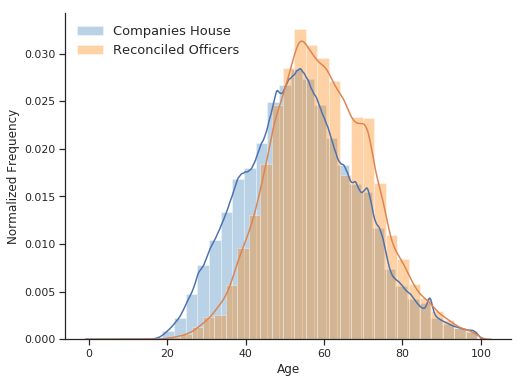

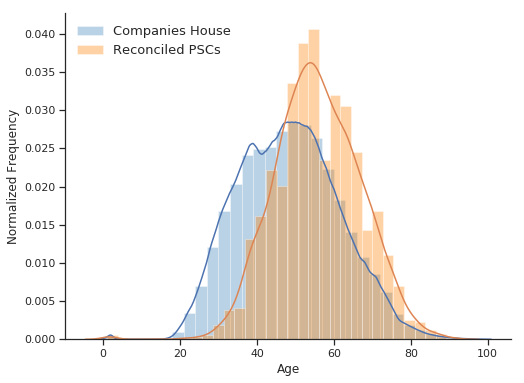

In [14]:
sns.set(style='ticks')
f, (ax1) = plt.subplots(1, 1, figsize=(8,6))
g = sns.distplot(ch_officers_age_filtered,
                 ax=ax1,bins=33,
                 kde_kws={'gridsize':500},
                 hist_kws={'color':'#377eb8', 'alpha':0.35},
                 label = 'Companies House')
g = sns.distplot(recon_officers_age_filtered,
                 ax=ax1,bins=33,
                 kde_kws={'gridsize':500},
                 hist_kws={'color':'#ff7f00', 'alpha':0.35},
                 label = 'Reconciled Officers')
ax1.set_ylabel("Normalized Frequency",fontsize=12)
ax1.set_xlabel("Age",fontsize=12)
sns.despine()
g.legend(loc='upper left',edgecolor='k',frameon=False, fontsize=13)
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'officers_age.pdf')), bbox_inches='tight')
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'officers_age.png')), dpi=600, bbox_inches='tight')

f, (ax1) = plt.subplots(1, 1, figsize=(8,6))
g = sns.distplot(ch_psc_age_filtered, ax=ax1,
                 kde_kws={'gridsize':500},bins=33,
                 hist_kws={'color':'#377eb8', 'alpha':0.35},
                 label = 'Companies House')
g = sns.distplot(recon_psc_age_filtered, ax=ax1,bins=33,
                 kde_kws={'gridsize':500},
                 hist_kws={'color':'#ff7f00', 'alpha':0.35},
                 label = 'Reconciled PSCs')
ax1.set_ylabel("Normalized Frequency",fontsize=12)
ax1.set_xlabel("Age",fontsize=12)
sns.despine()
g.legend(loc='upper left',edgecolor='k',frameon=False, fontsize=13)
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'psc_age.pdf')), bbox_inches='tight')
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'psc_age.png')), dpi=600, bbox_inches='tight')

In [15]:
print('The average age of Companies House officers is ' + 
      str(round(ch_officers_age['Age'].mean(),2)) + ' years.')
print('The average age of officers in government supplying companies is ' + 
      str(round(recon_officers_age['Age'].mean(),2)) + ' years.')
print('The average age of Companies House PSC is ' + 
      str(round(ch_psc_age['Age'].mean(),2)) + ' years.')
print('The average age of PSC in government supplying companies is ' + 
      str(round(recon_psc_age['Age'].mean(),2)) + ' years.')

The average age of Companies House officers is 54.42 years.
The average age of officers in government supplying companies is 59.36 years.
The average age of Companies House PSC is 48.13 years.
The average age of PSC in government supplying companies is 55.81 years.


### Section 6.2 Compare Officer and PSC Gender in CH and the Subset of ```centgovspend``` Procurers

In [16]:
def clean_officer_names(x):
    try:
        if len(x.split(' '))>=1:
            return x.split(' ')[1]
    except IndexError:
        pass

ch_officers_gen = ch_officers.copy()
ch_officers_gen = ch_officers_gen[ch_officers_gen['Name'].notnull()]
ch_officers_gen.loc[:,'Forename'] = ch_officers_gen['Name'].apply(
    lambda x: clean_officer_names(x))
ch_officers_gen.loc[:,'CleanGender'] = ch_officers_gen['Forename'].apply(
    lambda x: gendet.get_gender(x))
ch_officers_gen.loc[:,'MaleFemale'] = ch_officers_gen['CleanGender'].str.replace(
    'mostly_', '')
ch_officers_gen.loc[:,'isfemale'] = np.where(
    ch_officers_gen['MaleFemale'] == 'female', 1, 0)
ch_officers_gen = ch_officers_gen[(ch_officers_gen['MaleFemale'] == 'male') | (
    ch_officers_gen['MaleFemale'] == 'female')]

recon_officers_gen = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_gen, how='left', left_on='company_number',
                                right_on='CompanyNumber')
recon_officers_gen = recon_officers_gen[(recon_officers_gen['MaleFemale'] == 'male') | (
    recon_officers_gen['MaleFemale'] == 'female')]

print('The percent of female officers in CH in total is: ' +
      str(round(ch_officers_gen['isfemale'].mean()*100,2)) + '%.')
print('The percent of female officers in companioes supplying the government is: ' +
      str(round(recon_officers_gen['isfemale'].mean()*100,2)) + '%.')

The percent of female officers in CH in total is: 29.45%.
The percent of female officers in companioes supplying the government is: 29.32%.


In [17]:
#def clean_psc_names(x):
#    if ('ltd' not in x.lower()) and ('limited' not in x.lower()):
#        x=x.replace('.','').strip()
#        x=x.replace('Mrs ','').strip()
#        x=x.replace('Mr ','').strip()
#        x=x.replace('Wing Commander','').strip()
#        x=x.replace('Miss ','').strip()
#        x=x.replace('Dr ','').strip()
#        x=x.replace('Ms ','').strip()
#        if len(x.split(' ')[0].title())>2:
#            return x.split(' ')[0].title()

ch_psc_gen = ch_psc.copy()
ch_psc_gen = ch_psc_gen[ch_psc_gen['forename'].notnull()]
#ch_psc_gen.loc[:,'Forename'] = ch_psc_gen['name'].apply(
#    lambda x: clean_psc_names(x))
ch_psc_gen.loc[:,'CleanGender'] = ch_psc_gen['forename'].apply(
    lambda x: gendet.get_gender(x))
ch_psc_gen['MaleFemale'] = ch_psc_gen['CleanGender'].str.replace(
    'mostly_', '')
ch_psc_gen['isfemale'] = np.where(
    ch_psc_gen['MaleFemale'] == 'female', 1, 0)
ch_psc_gen = ch_psc_gen[(ch_psc_gen['MaleFemale'] == 'male') | (
    ch_psc_gen['MaleFemale'] == 'female')]

recon_psc_gen = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_psc_gen, how='left', left_on='company_number',
                                right_on='company_number')
recon_psc_gen = recon_psc_gen[(recon_psc_gen['MaleFemale'] == 'male') | (
    recon_psc_gen['MaleFemale'] == 'female')]

print('The percent of female PSC in CH in total is: ' +
      str(round(ch_psc_gen['isfemale'].mean()*100, 4)) + '%.')
print('The percent of female PSC in the subset of companies supplying the government is: ' +
      str(round(recon_officers_gen['isfemale'].mean()*100,2)) + '%.')

The percent of female PSC in CH in total is: 27.7811%.
The percent of female PSC in the subset of companies supplying the government is: 29.32%.


### Section 6.3 Compare Officer and PSC Nationality and Country of Residence in CH and the Subset of ```centgovspend``` Procurers

First do the nationalities:

In [18]:
def clean_nationalities(x):
    x = x.lower().replace('english','british')
    x = x.lower().replace('scottish','british')
    x = x.lower().replace('welsh','british')
    x = x.lower().replace('northern irish','british')
    x = x.lower().replace('united kingdom', 'british')
    x = x.lower().replace('.','')
    x = x.lower().replace(',','')
    if x.lower()[0:2] == 'uk':
        x = 'british'
    return x.title()

ch_psc_nat = ch_psc.copy()
ch_psc_nat = ch_psc_nat[ch_psc_nat['nationality'].notnull()]
ch_psc_nat.loc[:,'nationality'] = ch_psc_nat['nationality'].apply(lambda x: clean_nationalities(x))
len_ch_psc_nat = len(ch_psc_nat[ch_psc_nat['nationality'].notnull()])
ch_psc_nat_pcs = ch_psc_nat['nationality'].value_counts().divide(len_ch_psc_nat/100)
ch_psc_nat_pcs = ch_psc_nat_pcs.sort_values(ascending=False)

recon_psc_nat = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_psc_nat, how='left', left_on='company_number',
                                right_on='company_number')
recon_psc_nat = recon_psc_nat[recon_psc_nat['nationality'].notnull()]
recon_psc_nat['nationality'] = recon_psc_nat['nationality'].map(lambda x: clean_nationalities(x))
len_recon_psc_nat = len(recon_psc_nat[recon_psc_nat['nationality'].notnull()])
recon_psc_nat_pcs = recon_psc_nat['nationality'].value_counts().divide(len_recon_psc_nat/100)
recon_psc_nat_pcs = recon_psc_nat_pcs.sort_values(ascending=False)

In [19]:
ch_officers_nat = ch_officers.copy()
ch_officers_nat = ch_officers_nat[ch_officers_nat['Nationality'].notnull()]
ch_officers_nat['Nationality'] = ch_officers_nat['Nationality'].map(lambda x: clean_nationalities(x))
len_ch_officers_nat = len(ch_officers_nat[ch_officers_nat['Nationality'].notnull()])
ch_officers_nat_pcs = ch_officers_nat['Nationality'].value_counts().divide(len_ch_officers_nat/100)
ch_officers_nat_pcs = ch_officers_nat_pcs.sort_values(ascending=False)

recon_officers_nat = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_nat, how='left', left_on='company_number',
                                right_on='CompanyNumber')
recon_officers_nat = recon_officers_nat[recon_officers_nat['Nationality'].notnull()]
recon_officers_nat['Nationality'] = recon_officers_nat['Nationality'].map(lambda x: clean_nationalities(x))
len_recon_officers_nat = len(recon_officers_nat[recon_officers_nat['Nationality'].notnull()])
recon_officers_nat_pcs = recon_officers_nat['Nationality'].value_counts().divide(len_recon_officers_nat/100)
recon_officers_nat_pcs = recon_officers_nat_pcs.sort_values(ascending=False)

Then do the country of residences:

In [20]:
def clean_countries(x):
    x = x.lower().replace('england','united kingdom')
    x = x.lower().replace('scotland','united kingdom')
    x = x.lower().replace('wales','united kingdom')
    x = x.lower().replace('northern ireland','united kingdom')
    x = x.lower().replace('britain','united kingdom')
    x = x.lower().replace('.','')
    x = x.lower().replace(',','')
    if x.lower()[0:2] == 'gb':
        x = 'united kingdom'
    return x.title()

ch_psc_cou = ch_psc.copy()
ch_psc_cou = ch_psc_cou[ch_psc_cou['country_of_residence'].notnull()]
ch_psc_cou['country_of_residence'] = ch_psc_cou['country_of_residence'].map(lambda x: clean_countries(x))
len_ch_psc_cou = len(ch_psc_cou[ch_psc_cou['country_of_residence'].notnull()])
ch_psc_cou_pcs = ch_psc_cou['country_of_residence'].value_counts().divide(len_ch_psc_cou/100)
ch_psc_cou_pcs = ch_psc_cou_pcs.sort_values(ascending=False)


recon_psc_cou = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_psc_cou, how='left', left_on='company_number',
                                right_on='company_number')
recon_psc_cou = recon_psc_cou[recon_psc_cou['country_of_residence'].notnull()]
len_recon_psc_cou = len(recon_psc_cou[recon_psc_cou['country_of_residence'].notnull()])
recon_psc_cou_pcs = recon_psc_cou['country_of_residence'].value_counts().divide(len_recon_psc_cou/100)
recon_psc_cou_pcs = recon_psc_cou_pcs.sort_values(ascending=False)

In [21]:
ch_officers_cou = ch_officers.copy()
ch_officers_cou = ch_officers_cou[ch_officers_cou['Country of Residence'].notnull()]
ch_officers_cou['Country of Residence'] = ch_officers_cou['Country of Residence'].apply(lambda x: clean_countries(x))
len_ch_officers_cou = len(ch_officers_cou[ch_officers_cou['Country of Residence'].notnull()])
ch_officers_cou_pcs = ch_officers_cou['Country of Residence'].value_counts().divide(len_ch_officers_cou/100)
ch_officers_cou_pcs = ch_officers_cou_pcs.sort_values(ascending=False)
recon_officers_cou = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_cou, how='left', left_on='company_number',
                                right_on='CompanyNumber')
recon_officers_cou = recon_officers_cou[recon_officers_cou['Country of Residence'].notnull()]
len_recon_officers_cou = len(recon_officers_cou[recon_officers_cou['Country of Residence'].notnull()])
recon_officers_cou_pcs = recon_officers_cou['Country of Residence'].value_counts().divide(len_recon_officers_cou/100)
recon_officers_cou_pcs = recon_officers_cou_pcs.sort_values(ascending=False)

Lets plot this as a figure:

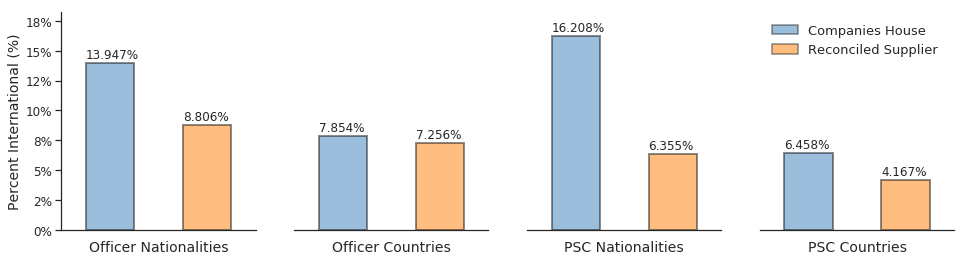

In [22]:
df_resi_nat = pd.DataFrame(index=['CH','Recon'],
                           columns=['Officer Countries',
                                    'Officer Nationalities',
                                    'PSC Countries',
                                    'PSC Nationalities'])

df_resi_nat.loc['Recon','Officer Countries'] = 100-recon_officers_cou_pcs['United Kingdom']
df_resi_nat.loc['CH','Officer Countries'] = 100-ch_officers_cou_pcs['United Kingdom']
df_resi_nat.loc['Recon','PSC Countries'] = 100-recon_psc_cou_pcs['United Kingdom']
df_resi_nat.loc['CH','PSC Countries'] = 100-ch_psc_cou_pcs['United Kingdom']
df_resi_nat.loc['Recon','Officer Nationalities'] = 100-recon_officers_nat_pcs['British']
df_resi_nat.loc['CH','Officer Nationalities'] = 100-ch_officers_nat_pcs['British']
df_resi_nat.loc['Recon','PSC Nationalities'] = 100-recon_psc_nat_pcs['British']
df_resi_nat.loc['CH','PSC Nationalities'] = 100-ch_psc_nat_pcs['British']

fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(16,4))
sns.set_style("ticks")

a = df_resi_nat['Officer Nationalities'].plot(kind='bar',
                                              ax=axes[0],
                                              color=['#377eb8','#ff7f00'],
                                              alpha=0.5,
                                              edgecolor='k',
                                              linewidth=2)
b = df_resi_nat['Officer Countries'].plot(kind='bar',
                                          ax=axes[1],
                                          color=['#377eb8','#ff7f00'],
                                          alpha=0.5,
                                          edgecolor='k',
                                          linewidth=2)
c = df_resi_nat['PSC Nationalities'].plot(kind='bar',
                                          ax=axes[2],
                                          color=['#377eb8','#ff7f00'],
                                          alpha=0.5,
                                          edgecolor='k',
                                          linewidth=2)
d = df_resi_nat['PSC Countries'].plot(kind='bar',
                                      ax=axes[3],
                                      color=['#377eb8','#ff7f00'],
                                      alpha=0.5,
                                      edgecolor='k',
                                      linewidth=2,
                                      legend=True)


CH = patches.Patch(facecolor='#377eb8', label='Companies House',
                   alpha=0.5,edgecolor='k',linewidth=1.5)
Recon = patches.Patch(facecolor='#ff7f00', label='Reconciled Supplier',
                      alpha=0.5,edgecolor='k',linewidth=1.5)
plt.legend(handles=[CH,Recon], loc=2,fontsize=13, edgecolor='k',
           frameon=False)

a.set_xlabel("Officer Nationalities",fontsize=14,labelpad=10)
b.set_xlabel("Officer Countries",fontsize=14,labelpad=10)
c.set_xlabel("PSC Nationalities",fontsize=14,labelpad=10)
d.set_xlabel("PSC Countries",fontsize=14,labelpad=10)

for axy in [a,b,c,d]:
    axy.set_ylim(0, df_resi_nat.max().max()+2)
    axy.axes.get_xaxis().set_ticks([])
    for p in axy.patches:
        axy.annotate(str(round(p.get_height(),3))+'%', (p.get_x(), p.get_height() + 0.4))
    if axy!=a:
        sns.despine(ax=axy, left=True, bottom = False, right = True)
        #axy.yaxis.set_tick_position('none') 
        axy.axes.get_yaxis().set_visible(False)
    else:
        sns.despine(ax=axy, left=False, bottom = False, right = True)
        axy.set_ylabel("Percent International (%)",fontsize=14)
        vals = axy.get_yticks()
        axy.set_yticklabels(['{:,.0%}'.format(x/100) for x in vals],fontsize=12)

fig.subplots_adjust(hspace=25)
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'countries_and_nationalities.pdf')),
            bbox_inches='tight')
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'countries_and_nationalities.png')),
            dpi=600, bbox_inches='tight')

### Section 6.4 Compare Officer Occupations in CH and the Subset of ```centgovspend``` Procurers

Not included in the paper, but lets look at the occupations of the Officers:

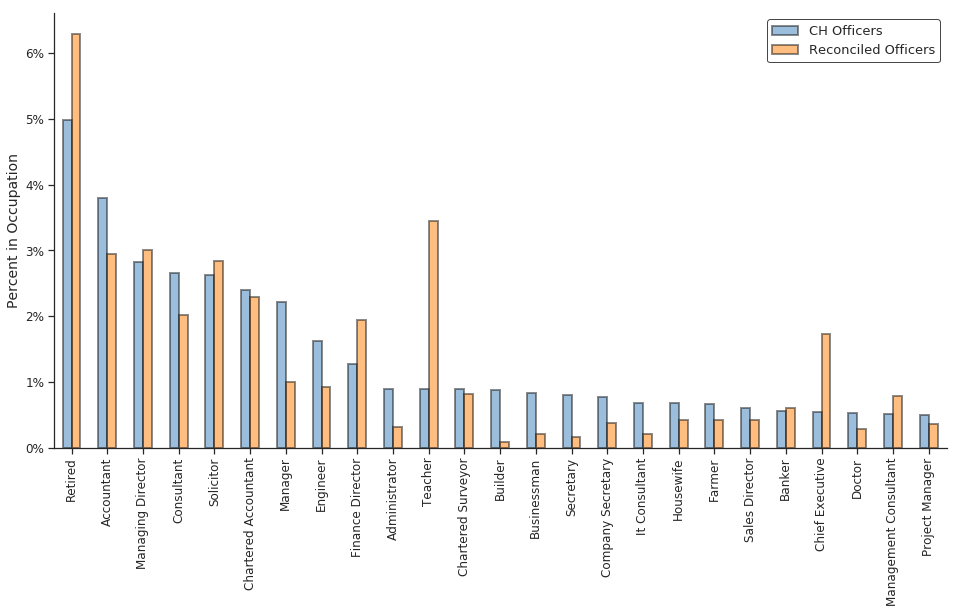

In [23]:
def clean_occupations(x):
    x = x.replace('.','')
    x = x.replace(',','')
    return x.title()

ch_officers_occ = ch_officers[ch_officers['Occupation'].notnull()]
ch_officers_occ = ch_officers_occ[ch_officers_occ['Occupation']!='Director']
ch_officers_occ = ch_officers_occ[ch_officers_occ['Occupation']!='Company Director']
ch_officers_occ = ch_officers_occ[ch_officers_occ['Occupation']!='None']
ch_officers_occ['Occupation'] = ch_officers_occ['Occupation'].map(lambda x: clean_occupations(x))
len_ch_officers_occ = len(ch_officers_occ[ch_officers_occ['Occupation'].notnull()])
ch_officers_occ_pcs = ch_officers_occ['Occupation'].value_counts().divide(len_ch_officers_occ/100)
ch_officers_occ_pcs = ch_officers_occ_pcs.sort_values(ascending=False)

recon_officers_occ = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_occ, how='left', left_on='company_number',
                                right_on='CompanyNumber')
len_recon_officers_occ = len(recon_officers_occ[recon_officers_occ['Occupation'].notnull()])
recon_officers_occ_pcs = recon_officers_occ['Occupation'].value_counts().divide(len_recon_officers_occ/100)
recon_officers_occ_pcs = recon_officers_occ_pcs.sort_values(ascending=False)

both_officers_occ_pcs = pd.merge(pd.DataFrame(ch_officers_occ_pcs),
                                 pd.DataFrame(recon_officers_occ_pcs),
                                 left_index=True, right_index=True)
both_officers_occ_pcs = both_officers_occ_pcs.rename({'Occupation_x':'CH Officers',
                                                      'Occupation_y': 'Reconciled Officers'},axis=1)
sns.set_style("ticks")
a = both_officers_occ_pcs[0:25].plot(kind='bar', figsize=(16,8),
                                     color=['#377eb8','#ff7f00'],
                                     alpha=0.5,
                                     edgecolor='k',
                                     linewidth=2)
a.set_ylabel("Percent in Occupation",fontsize=14)
vals = a.get_yticks()
a.set_yticklabels(['{:,.0%}'.format(x/100) for x in vals],fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(loc='upper right',fontsize=13, edgecolor='k')
sns.despine()

fig = a.get_figure()

fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'officer_occupations.pdf')), bbox_inches='tight')
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'officer_occupations.png')), dpi=600, bbox_inches='tight')